In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# LOAD AND PREP DATA
# -----------------------------
df = pd.read_excel('/Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/Sample Non-profit Data 2015-2025.xlsx')

df["date"] = pd.to_datetime(
    df["Fiscal Year-Month Label"].str.replace(" - ", "-") + "-01"
)
df = df.set_index("date").sort_index()

# -----------------------------
# TARGET VARIABLE
# -----------------------------
y = df["Cancellations"]

# -----------------------------
# EXOGENOUS VARIABLES
# Why: cancellations depend heavily on donor flow + donor quality.
# -----------------------------
exog = df[[
    "Active Donors Start of Month",
    "New Donors",
    "Average Amount (Active)"
]]


In [18]:
train_end = "2022-12-01"
val_end = "2024-12-01"

y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

exog_train = exog.loc[y_train.index]
exog_val   = exog.loc[y_val.index]
exog_test  = exog.loc[y_test.index]


In [19]:
def adf_test(series, title=""):
    result = adfuller(series.dropna())
    print(f"ADF Test: {title}")
    print(f"  Statistic: {result[0]}")
    print(f"  p-value:   {result[1]}\n")

adf_test(y_train, "Original")
adf_test(y_train.diff(), "1st difference (d=1)")
adf_test(y_train.diff(12), "Seasonal difference (D=1)")
adf_test(y_train.diff().diff(12), "d=1 + D=1")


ADF Test: Original
  Statistic: -2.1463947214236097
  p-value:   0.2262726502778324

ADF Test: 1st difference (d=1)
  Statistic: -1.6422616480369656
  p-value:   0.46107926176439223

ADF Test: Seasonal difference (D=1)
  Statistic: -1.0071534880474091
  p-value:   0.7506462970908434

ADF Test: d=1 + D=1
  Statistic: -1.902913747506487
  p-value:   0.33069163592929096



In [20]:
p_vals = [0, 1, 2]
d_vals = [0]       # force no differencing
q_vals = [0, 1, 2]

P_vals = [0, 1]
D_vals = [0]       # force no seasonal differencing
Q_vals = [0, 1]

m = 12


In [21]:
def sarimax_grid_search(y_train, y_val, exog_train, exog_val,
                        p_vals, d_vals, q_vals,
                        P_vals, D_vals, Q_vals, m):

    best_rmse = np.inf
    best_cfg = None

    for p, d, q, P, D, Q in itertools.product(
            p_vals, d_vals, q_vals,
            P_vals, D_vals, Q_vals):

        order = (p, d, q)
        seasonal = (P, D, Q, m)

        try:
            model = SARIMAX(
                y_train,
                exog=exog_train,
                order=order,
                seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            fit = model.fit(disp=False)

            # Forecast validation range
            pred = fit.get_forecast(steps=len(y_val), exog=exog_val).predicted_mean
            rmse = np.sqrt(mean_squared_error(y_val, pred))

            print(f"{order} x {seasonal} → RMSE {rmse:.2f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_cfg = (order, seasonal)

        except:
            continue

    print("\nBest model:")
    print(best_cfg, "RMSE:", best_rmse)
    return best_cfg


In [22]:
best_cfg = sarimax_grid_search(
    y_train, y_val,
    exog_train, exog_val,
    p_vals, d_vals, q_vals,
    P_vals, D_vals, Q_vals, m
)

order, seasonal = best_cfg


(0, 0, 0) x (0, 0, 0, 12) → RMSE 99.34
(0, 0, 0) x (0, 0, 1, 12) → RMSE 63.39
(0, 0, 0) x (1, 0, 0, 12) → RMSE 74.65
(0, 0, 0) x (1, 0, 1, 12) → RMSE 148.82
(0, 0, 1) x (0, 0, 0, 12) → RMSE 83.82
(0, 0, 1) x (0, 0, 1, 12) → RMSE 73.83
(0, 0, 1) x (1, 0, 0, 12) → RMSE 119.42
(0, 0, 1) x (1, 0, 1, 12) → RMSE 114.46
(0, 0, 2) x (0, 0, 0, 12) → RMSE 67.28
(0, 0, 2) x (0, 0, 1, 12) → RMSE 72.91
(0, 0, 2) x (1, 0, 0, 12) → RMSE 112.67
(0, 0, 2) x (1, 0, 1, 12) → RMSE 73.83
(1, 0, 0) x (0, 0, 0, 12) → RMSE 66.47
(1, 0, 0) x (0, 0, 1, 12) → RMSE 63.19
(1, 0, 0) x (1, 0, 0, 12) → RMSE 55.83
(1, 0, 0) x (1, 0, 1, 12) → RMSE 65.72
(1, 0, 1) x (0, 0, 0, 12) → RMSE 60.65
(1, 0, 1) x (0, 0, 1, 12) → RMSE 66.31
(1, 0, 1) x (1, 0, 0, 12) → RMSE 57.94
(1, 0, 1) x (1, 0, 1, 12) → RMSE 106.83
(1, 0, 2) x (0, 0, 0, 12) → RMSE 160.14
(1, 0, 2) x (0, 0, 1, 12) → RMSE 70.95
(1, 0, 2) x (1, 0, 0, 12) → RMSE 56.35
(1, 0, 2) x (1, 0, 1, 12) → RMSE 86.99
(2, 0, 0) x (0, 0, 0, 12) → RMSE 63.61
(2, 0, 0) x (0, 0, 

In [23]:
y_trainval = pd.concat([y_train, y_val])
exog_trainval = pd.concat([exog_train, exog_val])

final_model = SARIMAX(
    y_trainval,
    exog=exog_trainval,
    order=order,
    seasonal_order=seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_fit = final_model.fit(disp=False)

# Test forecast
test_pred = final_fit.get_forecast(
    steps=len(y_test),
    exog=exog_test
).predicted_mean

test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test RMSE:", test_rmse)


Test RMSE: 85.4802333760166


In [24]:
y_full = y
exog_full = exog

model_full = SARIMAX(
    y_full,
    exog=exog_full,
    order=order,
    seasonal_order=seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
fit_full = model_full.fit(disp=False)

# Build future date index
future_index = pd.date_range(
    start=y_full.index.max() + pd.offsets.MonthBegin(1),
    periods=24,
    freq="MS"
)

# Exog future
exog_future_mean = exog_full.iloc[-12:].mean()
exog_future = pd.DataFrame(
    [exog_future_mean.values] * 24,
    index=future_index,
    columns=exog_full.columns
)

future_pred = fit_full.get_forecast(
    steps=24,
    exog=exog_future
).predicted_mean
forecast_output = pd.DataFrame({
    "Date": future_pred.index,
    "Forecast_Active_Donors_Start_of_Month": future_pred.values
})
forecast_output["Date"] = pd.to_datetime(forecast_output["Date"])



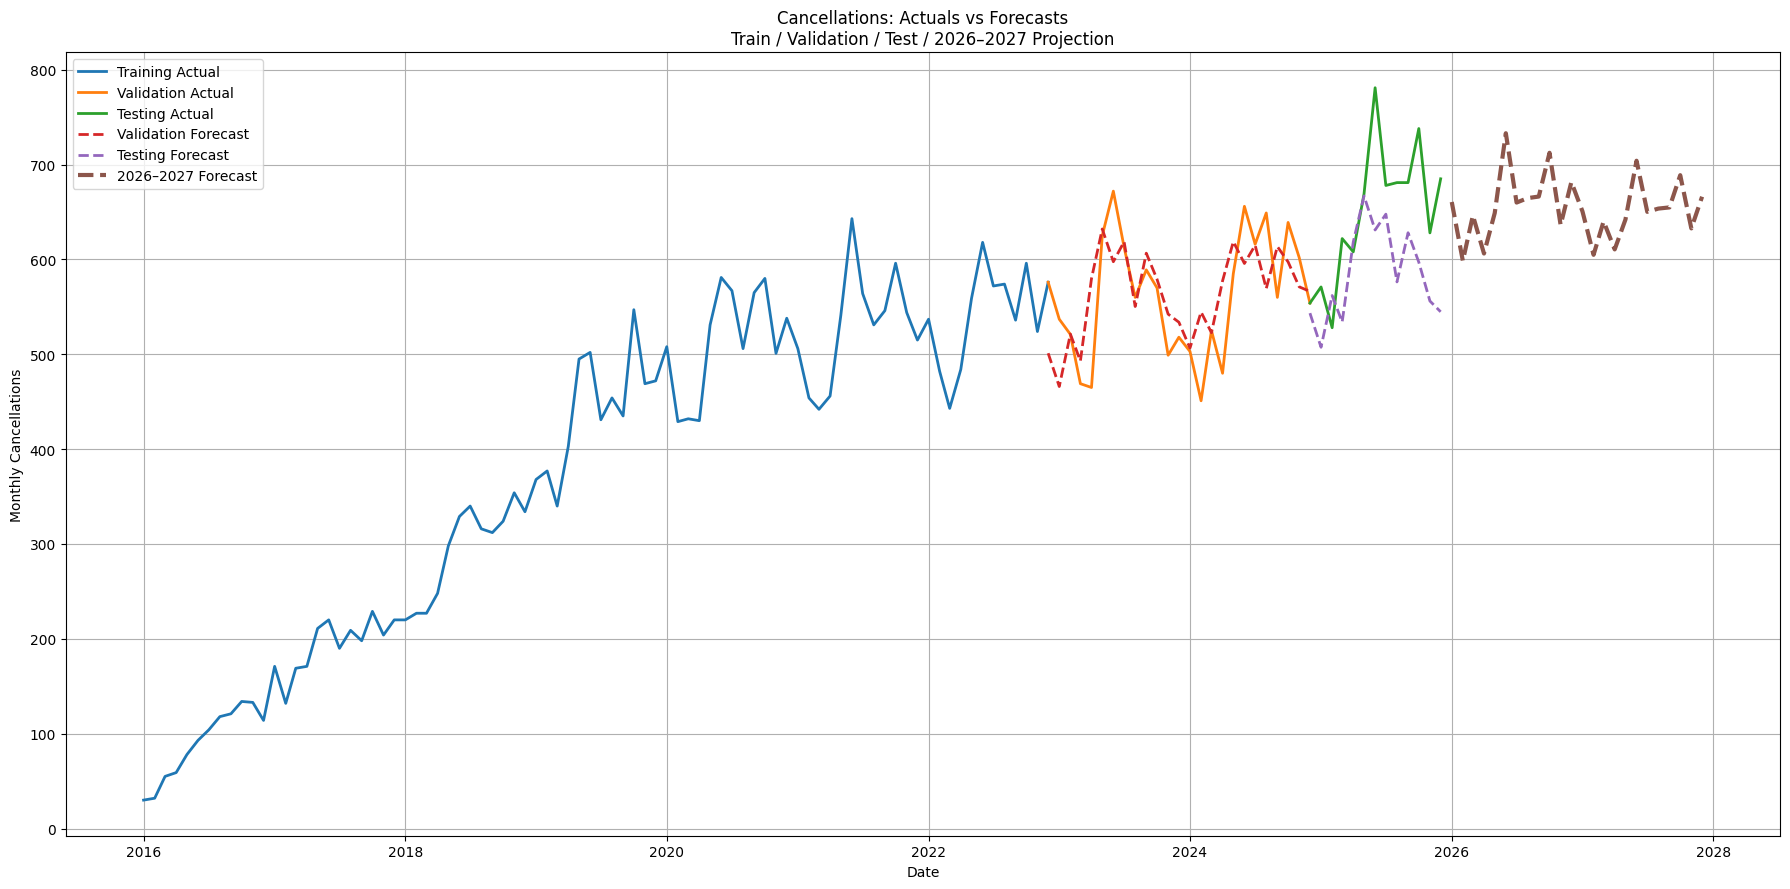

In [25]:
plt.figure(figsize=(18,9))

plt.plot(y_train.index, y_train, label="Training Actual", linewidth=2)
plt.plot(y_val.index,   y_val,   label="Validation Actual", linewidth=2)
plt.plot(y_test.index,  y_test,  label="Testing Actual", linewidth=2)

plt.plot(y_val.index,   final_fit.get_forecast(
    steps=len(y_val), exog=exog_val).predicted_mean,
    "--", label="Validation Forecast", linewidth=2)

plt.plot(y_test.index,  test_pred,
    "--", label="Testing Forecast", linewidth=2)

plt.plot(future_pred.index, future_pred,
    "--", label="2026–2027 Forecast", linewidth=3)

plt.title("Cancellations: Actuals vs Forecasts\nTrain / Validation / Test / 2026–2027 Projection")
plt.xlabel("Date")
plt.ylabel("Monthly Cancellations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# ================================================
# 1. Create next-year (12-month) date index
# ================================================
future_index_12 = pd.date_range(
    start=y_full.index.max() + pd.offsets.MonthBegin(1),
    periods=12,
    freq="MS"
)

# ================================================
# 2. Build future exogenous data for 12 months
# ================================================
exog_future_mean_12 = exog_full.iloc[-12:].mean()

exog_future_12 = pd.DataFrame(
    [exog_future_mean_12.values] * 12,
    index=future_index_12,
    columns=exog_full.columns
)

# ================================================
# 3. Forecast next 12 months of cancellations
# ================================================
forecast_12 = fit_full.get_forecast(
    steps=12,
    exog=exog_future_12
).predicted_mean

# ================================================
# 4. Build a printable DataFrame
# ================================================
forecast_df_12 = pd.DataFrame({
    "Forecasted Cancellations": forecast_12
})

print("\n===== 12-Month Cancellation Forecast =====\n")
print(forecast_df_12)




===== 12-Month Cancellation Forecast =====

            Forecasted Cancellations
2026-01-01                660.556932
2026-02-01                598.447882
2026-03-01                646.351159
2026-04-01                606.222012
2026-05-01                648.890024
2026-06-01                733.048961
2026-07-01                659.967453
2026-08-01                664.638834
2026-09-01                666.303572
2026-10-01                712.418263
2026-11-01                636.269480
2026-12-01                681.625225


In [27]:
# ============================================
# SAVE FORECAST TO SAME FOLDER AS INPUT FILE
# ============================================

from pathlib import Path
import pandas as pd  # in case not already imported

# 1. Path of the input file you originally read
input_path = Path("/Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/Sample Non-profit Data 2015-2025.xlsx")

# 2. Extract the parent folder
output_folder = input_path.parent

# 3. Build the output path inside that same folder
output_path = output_folder / "forecast_output.xlsx"

# 4. Write the DataFrame to Excel using openpyxl
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    forecast_output.to_excel(writer, index=False, sheet_name="Forecast")

print(f"Forecast saved to: {output_path}")


Forecast saved to: /Users/noahmancione/OneDrive/Noah Python Projects/Capstone Project/forecast_output.xlsx
